# Transfer Learning with Keras

This project uses data from Kaggle's dogs and cats dataset, making it a classification problem. In this notebook, you will implement Google's [Xception](https://keras.io/api/applications/xception/) for this problem. Also, you will learn how to implement your own dataset and using extra layers for feature extraction.

### Import libraries for the project

This notebook uses Tensorflow 2 and its high level API Keras. Matplotlib is also imported to plot the images from the dataset.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from matplotlib import pyplot as plt

### ImageDataGenerator

With Keras' ImageDataGenerator class, we can augment our dataset by applying small changes to it in real time while training. This creates a better variation from the original images, which makes for better accuracy.

In [20]:
IMAGE_SHAPE = (128, 128, 3)
PATH = '../input/cat-and-dog/training_set/training_set/' # put your own path to the dataset here

generator = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.1,
    validation_split = 0.2,
    horizontal_flip = True,
    rotation_range = 20
)

train = generator.flow_from_directory(
    directory = PATH,
    shuffle = True,
    target_size = IMAGE_SHAPE[:2],
    subset = 'training',
    class_mode = 'categorical'
)

val = generator.flow_from_directory(
    directory = PATH,
    shuffle = True,
    subset = 'validation',
    class_mode = 'categorical'
)

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.


### Transfer Learning with Xception

Here is the interesting part! We will add Xception as a base model, freeze it with trainable = False and then add a trainable feature extraction layer and a prediction Dense layer. Also, we will use the pretrained model with ImageNet weights. [Here's the full list of models available!](https://keras.io/api/applications/)

In [21]:
base_model = keras.applications.Xception(
    weights = 'imagenet',
    input_shape = IMAGE_SHAPE,
    include_top = False # set to false to add custom prediction layers
)

In [22]:
base_model.trainable = False # freeze Xception's weights
inputs = keras.Input(shape = IMAGE_SHAPE) # add custom input size layer
x = base_model(inputs)

x = keras.layers.Conv2D(64, 3, activation = 'relu')(x) # trainable feature extraction layer
x = keras.layers.GlobalAveragePooling2D()(x) # global pooling layer

outputs = keras.layers.Dense(2, activation = 'softmax')(x) # final decision layer

model = keras.Model(inputs, outputs) # declare model

model.summary() # print model parameters and layers

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 2, 64)          1179712   
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 22,041,322
Trainable params: 1,179,842
Non-trainable params: 20,861,480
_________________________________________________________________


### Training the model

After creating our model, using the Adam optimizer is recommended. Try playing with the learning rate and batch size to see if you can get better results!

In [24]:
model.compile(optimizer = keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(train, epochs = 5, validation_data = val, batch_size = 32)

Epoch 1/5
201/201 [==============================] - 75s 361ms/step - loss: 0.4312 - accuracy: 0.8847 - val_loss: 0.0614 - val_accuracy: 0.9856
Epoch 2/5
201/201 [==============================] - 65s 324ms/step - loss: 0.1825 - accuracy: 0.9242 - val_loss: 0.0657 - val_accuracy: 0.9850
Epoch 3/5
201/201 [==============================] - 66s 327ms/step - loss: 0.1433 - accuracy: 0.9421 - val_loss: 0.0491 - val_accuracy: 0.9863
Epoch 4/5
201/201 [==============================] - 65s 322ms/step - loss: 0.1393 - accuracy: 0.9472 - val_loss: 0.0485 - val_accuracy: 0.9850
Epoch 5/5
201/201 [==============================] - 65s 323ms/step - loss: 0.1282 - accuracy: 0.9492 - val_loss: 0.0537 - val_accuracy: 0.9894


### Conclusion

Our model reached a validation accuracy of 98%, which is really good! You can try to use other models to apply transfer learning to, and check if you can get better results!

### Predict

Lets try our model with an unseen image from the test dataset! You can also use your own pet images to test the model!

In [40]:
from PIL import Image
img = '../input/cat-and-dog/test_set/test_set/dogs/dog.4001.jpg' # path to random image from test set
img = Image.open(img)
img = img.resize((128, 128), Image.ANTIALIAS) # resize our image

numeric_img = np.array(img)
numeric_img = numeric_img/255 # scale to [0, 1] for our model to predict

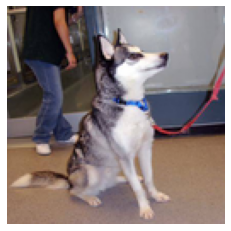

In [41]:
# plot example image
plt.axis(False)
plt.imshow(numeric_img)

In [42]:
# create prediction from our model (reshape to a batch size of 1)
prediction = np.argmax(model(np.reshape(numeric_img, (1, 128, 128, 3))))

In [43]:
# print final decision -- our model is correct!

if prediction == 0:
    print('Predicted Cat')
else:
    print('Predicted Dog')

Predicted Dog
